In [1]:
from __future__ import print_function

# Basics

The LSL interface for DRX (beam formed) data is similar to that of TBN.  

First, download a snippet of DRX data:

In [2]:
# This may take a bit...
import os
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
from tempfile import mkdtemp
from lsl.reader import drx

TEMPDIR = mkdtemp()
DRX_FILE = os.path.join(TEMPDIR, 'temp.drx')

fh1 = urlopen('https://lda10g.alliance.unm.edu/tutorial/Jupiter/055917_000007389_Jupiter.dat')
fh2 = open(DRX_FILE, 'wb')
fh2.write(fh1.read(drx.FRAME_SIZE*300))
fh1.close()
fh2.close()

print("DRX Size: %.1f kB" % (os.path.getsize(DRX_FILE)/1024.))

DRX Size: 1209.4 kB


To read in a chunk of data:

In [3]:
from lsl.reader import drx, errors

# Read in the first 5 frames
fh = open(DRX_FILE, 'rb')
for i in range(5):
    try:
        frame = drx.read_frame(fh)
    except errors.syncError:
        continue
    except errors.EOFError:
        break
        
    print("Beam: %i, Tuning: %i, Pol.: %i" % frame.id)
    print("-> Time tag: %i + %.6f s (%s)" % (frame.time[0], frame.time[1], frame.time))
    print("-> Mean value: %.3f + %.3f j" % (frame.payload.data.mean().real, frame.payload.data.mean().imag))
fh.close()

Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.601744 s (2011-12-22 01:01:10.601744)
-> Mean value: -0.009 + 0.000 j
Beam: 1, Tuning: 1, Pol.: 0
-> Time tag: 1324515670 + 0.601953 s (2011-12-22 01:01:10.601953)
-> Mean value: -0.018 + 0.010 j
Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.601953 s (2011-12-22 01:01:10.601953)
-> Mean value: 0.000 + 0.010 j
Beam: 1, Tuning: 1, Pol.: 0
-> Time tag: 1324515670 + 0.602162 s (2011-12-22 01:01:10.602161)
-> Mean value: 0.011 + -0.014 j
Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.602162 s (2011-12-22 01:01:10.602161)
-> Mean value: -0.020 + -0.006 j


The time tags reported in the above example are in seconds since the Unix epoch.  These can be converted to Python datetime instances through:

In [4]:
from datetime import datetime, timedelta

# Read in the first 5 frames
fh = open(DRX_FILE, 'rb')
for i in range(5):
    try:
        frame = drx.read_frame(fh)
    except errors.syncError:
        continue
    except errors.EOFError:
        break
        
    frame_time = datetime.utcfromtimestamp(frame.time[0])
    frame_time += timedelta(microseconds=int(frame.time[1]*1e6))
    
    print("Beam: %i, Tuning: %i, Pol.: %i" % frame.id)
    print("-> Time tag: %i + %.6f s (%s)" % (frame.time[0], frame.time[1], frame_time))
    print("-> Mean value: %.3f + %.3f j" % (frame.payload.data.mean().real, frame.payload.data.mean().imag))
fh.close()

Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.601744 s (2011-12-22 01:01:10.601744)
-> Mean value: -0.009 + 0.000 j
Beam: 1, Tuning: 1, Pol.: 0
-> Time tag: 1324515670 + 0.601953 s (2011-12-22 01:01:10.601953)
-> Mean value: -0.018 + 0.010 j
Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.601953 s (2011-12-22 01:01:10.601953)
-> Mean value: 0.000 + 0.010 j
Beam: 1, Tuning: 1, Pol.: 0
-> Time tag: 1324515670 + 0.602162 s (2011-12-22 01:01:10.602161)
-> Mean value: 0.011 + -0.014 j
Beam: 1, Tuning: 1, Pol.: 1
-> Time tag: 1324515670 + 0.602162 s (2011-12-22 01:01:10.602161)
-> Mean value: -0.020 + -0.006 j


## Creating Spectra

Similar to TBW and TBN data, you can easily create spectra with SpecMaster.  The following example reads and processes the first two frames in a DRX file:

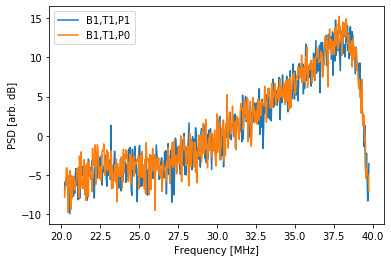

In [5]:
%matplotlib inline
import numpy
from lsl.correlator import fx as fxc
from lsl.misc.mathutils import to_dB
from matplotlib import pyplot as plt

fh = open(DRX_FILE, 'rb')
frame1 = drx.read_frame(fh)
frame2 = drx.read_frame(fh)
srate = frame1.sample_rate      # Data sample rate in Hz
cFreq = frame1.central_freq     # Data tuning in Hz

# SpecMaster expects 2-D data
data = numpy.zeros((2,frame1.payload.data.size), dtype=frame1.payload.data.dtype)
data[0,:] = frame1.payload.data
data[1,:] = frame2.payload.data

freq, spec = fxc.SpecMaster(data, LFFT=512, sample_rate=srate, central_freq=cFreq) 

fig = plt.figure()
ax = fig.gca()
ax.plot(freq/1e6, to_dB(spec[0,:]), label='B%i,T%i,P%i' % frame1.id)
ax.plot(freq/1e6, to_dB(spec[1,:]), label='B%i,T%i,P%i' % frame2.id)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()

To integrate down you need to read in more data and save it to a NumpyArray.  To read in 50 frames from each tuning/polarization use:

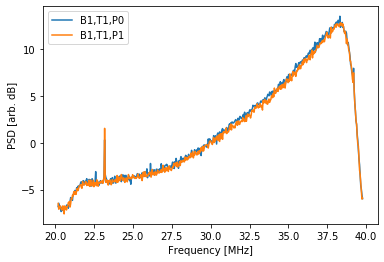

In [6]:
data = numpy.zeros((4,50*4096), dtype=numpy.complex64)
count = [0,0,0,0]

for i in range(50):
    for j in range(2):
        frame = drx.read_frame(fh)
        srate = frame.sample_rate      # Data sample rate in Hz
        cFreq = frame.central_freq     # Data tuning in Hz
        
        beam,tune,pol = frame.id
        k = 2*(tune-1) + pol
        data[k, count[k]*4096:(count[k]+1)*4096] = frame.payload.data
        count[k] += 1
        
freq, spec = fxc.SpecMaster(data, LFFT=512, sample_rate=srate, central_freq=cFreq) 

fig = plt.figure()
ax = fig.gca()
ax.plot(freq/1e6, to_dB(spec[0,:]), label='B%i,T%i,P%i' % (beam,tune,0))
ax.plot(freq/1e6, to_dB(spec[1,:]), label='B%i,T%i,P%i' % (beam,tune,1))
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()

## Computing Stokes Parameters

LSL also supports computing all four Stokes parameters from data using the StokesMaster function.  Using this function requires a little more setup since the function needs to know which singals are from which beam/tuning/polarization.  This is done by first creating "dummy" lsl.common.stations.Antenna instances to store the mapping:

In [7]:
from lsl.common import stations

antennas = []
for i in range(2):
    if i / 2 == 0:
        newAnt = stations.Antenna(1)
    else:
        newAnt = stations.Antenna(2)
    if i % 2 == 0:
        newAnt.pol = 0
    else:
        newAnt.pol = 1
    newAnt.digitizer = i+1
    antennas.append(newAnt)
    
for ant in antennas:
    print(str(ant))

Antenna 1: stand=0, polarization=0; digitizer 1; status is 0
Antenna 2: stand=0, polarization=1; digitizer 2; status is 0


Now the data can be passed into StokesMaster and the results plotted:

(512,) (4, 1, 512)


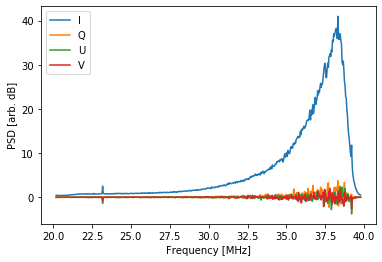

In [8]:
freq, spec = fxc.StokesMaster(data, antennas, LFFT=512, sample_rate=srate, central_freq=cFreq)
print(freq.shape, spec.shape)

fig = plt.figure()
ax = fig.gca()
ax.plot(freq/1e6, spec[0,0,:], label='I')
ax.plot(freq/1e6, spec[1,0,:], label='Q')
ax.plot(freq/1e6, spec[2,0,:], label='U')
ax.plot(freq/1e6, spec[3,0,:], label='V')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()

Note that the shape of the output spectra is 3-D in the case of StokesMaster as opposed to 2-D for SpecMaster.  The extra dimension stores the four Stokes parameters in the other of I, Q, U, and V.

# Additional Info
In addition to the modules provided in LSL there are also a variety of scripts in the [commissioning repo](https://github.com/lwa-project/commissioning) to analyze data.
